In [46]:
import numpy as np
import pandas as pd

import json
import bz2

import regex

from bs4 import BeautifulSoup

import gensim
from gensim.models import word2vec 
import nltk
import nltk.data
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
nltk.download('punkt')

from tqdm import tqdm
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import torch
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vladimir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:25, 1383.83it/s]


In [48]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

In [49]:
def json_to_pd(review):
    city = []
    rating_not_checked = []
    title = []
    num_comments = []
    bank_license = []
    author = []
    bank_name = []
    datetime = []
    text = []
    rating_grade = []
    
    for rec in review:
        city.append(rec['city'])
        rating_not_checked.append(rec['rating_not_checked'])
        title.append(rec['title'])
        num_comments.append(rec['num_comments'])
        bank_license.append(rec['bank_license'])
        author.append(rec['author'])
        bank_name.append(rec['bank_name'])
        datetime.append(rec['datetime'])
        text.append(rec['text'])
        rating_grade.append(rec['rating_grade'])
    return pd.DataFrame(
        {
            'city': city,
            'rating_not_checked': rating_not_checked,
            'title': title,
            'num_comments': num_comments,
            'bank_license': bank_license,
            'author': author,
            'bank_name': bank_name,
            'datetime': datetime,
            'text': text,
            'rating_grade': rating_grade
            
        }
    )
        

In [50]:
df = json_to_pd(responses)

In [51]:
df.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [53]:
df_score = df[(df['rating_grade'].isna() == False) & (df['text'].isna() == False)].reset_index()[['text', 'rating_grade']]

In [54]:
df_score

,text,rating_grade
0,"Также как и многие давний клиент банка, был до...",2.0
1,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
2,Доброго времени! Вчера мне поступило смс-уведо...,1.0
3,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
4,Для оплаты коммунальных платежей пользуюсь пла...,1.0
...,...,...
88653,"Слишком большой банк, не всегда учитывает нашу...",5.0
88654,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
88655,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
88656,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [55]:
def review_to_wordlist(review, lemmatizer, remove_stopwords=False):
    # убираем ссылки
    review_text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review)
    # достаем сам текст
    # review_text = BeautifulSoup(review_text, "lxml").get_text()
    # оставляем только буквенные символы
    review_text = re.sub("[^а-яА-ЯёЁ]"," ", review_text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = review_text.lower().split()
    if remove_stopwords: # убираем стоп-слова
        russian_stopwords = stopwords.words("russian")
        #stops = stopwords.words("english")
        words = [w for w in words if not w in russian_stopwords]
    if lemmatizer:
        return([lemmatizer.parse(word)[0].normal_form for word in words])
    else:
        return words
    
def review_to_sentences(review, tokenizer, lemmatizer = None, remove_stopwords=False):
    # разбиваем обзор на предложения
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # применяем предыдущую функцию к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, lemmatizer, remove_stopwords))
    return sentences

## Задание 1. Составление словаре дя классификации по тональности

### 1.1 Разобьем коллекцию отзывов на предолжения

In [56]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
lemmatizer = MorphAnalyzer()

In [24]:
#sentences = []  
#print('Parsing sentences...')
#for review in tqdm(df['text']):
#    sentences += review_to_sentences(review, tokenizer, lemmatizer)

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [2:48:33<00:00, 15.18it/s]


In [28]:
sentences[0:2]

[['добрый', 'день'],
 ['я',
  'не',
  'являться',
  'клиент',
  'банка',
  'и',
  'поручитель',
  'по',
  'кредитный',
  'договор',
  'а',
  'также',
  'не',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'с',
  'банк',
  'по',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

In [26]:
#запись результатов в файл:
#with open('text_banki_lem.txt', 'w') as f:
#    for s in sentences:
#        f.write(' '.join(s))
#        f.write('\n')

In [57]:
#считать результаты из файла:
import csv
sentences = []
with open('text_banki_lem.txt', 'r', newline='') as csvfile:
    r = csv.reader(csvfile, delimiter=' ')
    sentences.append(list(r))
sentences = sentences[0]

In [58]:
sentences[:2]

[['добрый', 'день'],
 ['я',
  'не',
  'являться',
  'клиент',
  'банка',
  'и',
  'поручитель',
  'по',
  'кредитный',
  'договор',
  'а',
  'также',
  'не',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'с',
  'банк',
  'по',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

### 2.1 Обучим по коллекции преложений word2vec 

In [59]:
print("Training model...")

%time model_ru = word2vec.Word2Vec(sentences, workers=4, vector_size=300, min_count=10, window=10, sample=1e-3)

Training model...
Wall time: 4min 4s


Количество слов в модели:

In [60]:
print(len(model_ru.wv.key_to_index))

24554


### 1.3 Приведем несколько примеров решения стандартных текстов для word2vec

#### Тест на определение ближайших слов

In [61]:
model_ru.wv.most_similar("кредит", topn=10)

[('автокредит', 0.8103092908859253),
 ('ипотека', 0.679523766040802),
 ('ссуда', 0.6435874700546265),
 ('рассрочка', 0.6083589792251587),
 ('потребкредить', 0.6028062701225281),
 ('потреба', 0.5344616770744324),
 ('потребкредит', 0.5315954089164734),
 ('автокреда', 0.4723246097564697),
 ('долг', 0.45218077301979065),
 ('каско', 0.4330856204032898)]

#### Тест на аналогии

In [62]:
print(model_ru.wv.most_similar(positive=['созаёмщик', "мужчина"], negative=["собственник"], topn=1))

[('женщина', 0.6041557788848877)]


In [63]:
print(model_ru.wv.most_similar(positive=['кредит', "заявка"], negative=["ипотека"], topn=1))

[('анкета', 0.5360696315765381)]


In [64]:
print(model_ru.wv.most_similar(positive=['москва', "столица"], negative=["самара"], topn=1))

[('город', 0.6029494404792786)]


In [65]:
print(model_ru.wv.most_similar(positive=['созаёмщик', "мужчина"], negative=["собственник"], topn=1))

[('женщина', 0.6041557788848877)]


#### Тест на лишнее слово:

In [66]:
print(model_ru.wv.doesnt_match('кредит ипотека рассрочка ссуда долг'.split()))

долг


In [67]:
print(model_ru.wv.doesnt_match('кредит ипотека рассрочка ссуда подарок'.split()))

подарок


Вывод: словарь вплоне справляется с выделением групп слов, близких по смыслу

### 1.4 Построим визуализации

#### TSNE для для TOP500 по частоте встречаемости и определним осмысленные кластеры:

In [24]:
#рассчет частоты словаиз словаря в формате ('word', index, frequency)
vocab_freq =[]
for key in model_ru.wv.index_to_key:
    vocab_freq.append((key, model_ru.wv.key_to_index[key], model_ru.wv.get_vecattr(key, 'count')))

In [110]:
vocab_freq[:2]

[('в', 0, 1355398), ('я', 1, 1122833)]

In [179]:
#при выводе функции index_to_key все слова сортируются по убыванию по встречаемости
model_ru.wv.index_to_key[:2]

['в', 'я']

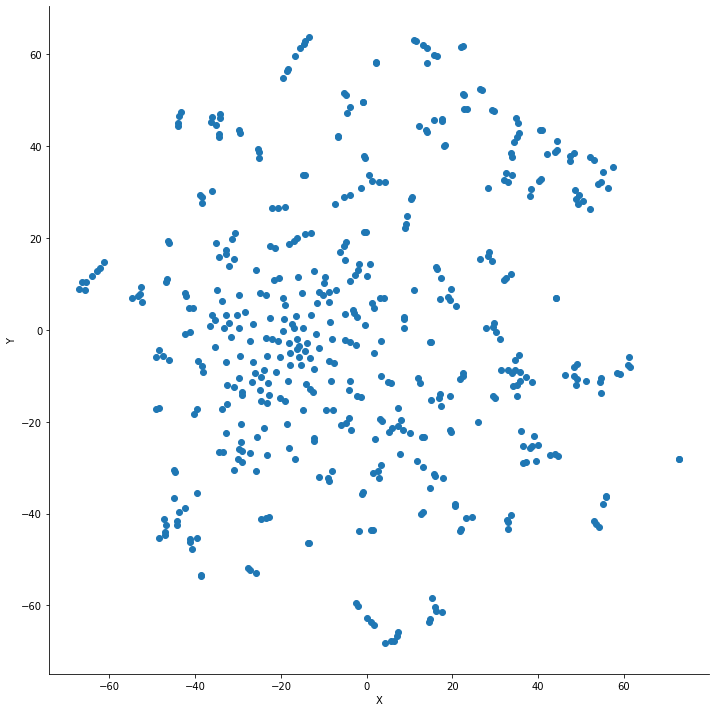

In [176]:
sample_size = 500
sample = model_ru.wv.vectors[:sample_size]
sample_embedded = TSNE(n_components=2, perplexity=5, verbose=0, random_state = 42).fit_transform(sample)
vis_df = pd.DataFrame({'X': sample_embedded[:, 0], 'Y': sample_embedded[:, 1]})
sns.FacetGrid(vis_df, size=10).map(plt.scatter, "X", "Y").add_legend()

Возьмем нижний участок, так как он точно вделяется среди остальных и отфильтруем в диапозоне Y<=-55, -30<X<30. похоже а какия-то информация или документы, заявки

In [197]:
for i, coord in enumerate(sample_embedded):
    if (coord[1] <= -55) & (coord[0] >= -30) & (coord[0] <= 30):
        print(model_ru.wv.index_to_key[i], coord)

заявление [  4.3264775 -68.28349  ]
документ [ 3.3133052e-02 -6.2697258e+01]
информация [ 15.324407 -58.368538]
смс [ 17.66266 -61.42312]
заявка [  1.6998128 -64.23801  ]
претензия [  5.681827 -67.81217 ]
обращение [  6.9575562 -66.67218  ]
письмо [ 14.75285  -63.011642]
выписка [ -2.3896637 -59.51939  ]
справка [ -2.0446491 -60.046677 ]
сообщение [ 16.124872 -61.114613]
почта [ 14.420549 -63.67429 ]
жалоба [  6.2965927 -67.81321  ]
запрос [  7.277669 -65.77873 ]
анкета [  1.0100335 -63.634438 ]
уведомление [ 15.845575 -60.427242]


Правый верхний участок в диапозоне Y >= 20, X>=15. похоже какие-то финансовые инструменты или действия над ними

In [207]:
for i, coord in enumerate(sample_embedded):
    if (coord[1] >= 20) & (coord[0] >= 15) & (coord[0] <= 70):
        print(model_ru.wv.index_to_key[i], coord)

получить [29.686357 47.755444]
платёж [53.919106 31.749092]
операция [53.10808 36.89167]
обратиться [18.197407 40.307873]
оформить [15.695681 59.80566 ]
перевод [52.058334 37.55628 ]
пользоваться [52.116714 26.227058]
взять [22.072521 61.65368 ]
приходить [23.475595 48.134373]
выдать [35.385944 44.980858]
прийти [17.58475  45.967205]
оплата [54.664932 32.288612]
пришлый [22.716894 48.040104]
оплатить [49.455845 29.31506 ]
снять [44.462418 39.16506 ]
вернуть [40.97449  43.525776]
погашение [56.278282 30.814192]
брать [22.415987 61.77307 ]
получать [29.17946  47.921715]
получение [35.1045 42.0677]
открыть [32.47585  34.157906]
платить [49.329647 27.467323]
отправить [22.537712 51.252487]
находиться [28.298418 30.961788]
внести [47.33205 36.81917]
предоставить [34.75686  46.157745]
закрыть [33.777122 33.74459 ]
обращаться [17.972319 39.966774]
оформление [34.342575 40.928925]
погасить [48.61326  30.528654]
заблокировать [38.374065 30.587425]
приехать [17.586607 45.481537]
закрытие [33.860

#### Найден координаты названий банков на осях "хорошо-плохо", "очередь-медленно"

берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами.

In [78]:
def bank_coord(model, x, y, bank_names):
    """
    Calculate coordinates x and y for bank names.
    model - word2vec mode;
    x, y - difference between  positive (index 0) and negative(index 1) characteristics. e.g. x = embedding("good") - embedding("bad").
    bank_names - list of bank names from vocabulary 
    """
    x_coord = []
    y_coord = []
    x_m = model.wv.get_vector(x[0]) - model.wv.get_vector(x[1])
    y_m = model.wv.get_vector(y[0]) - model.wv.get_vector(y[1])
    for bank in bank_names:
        x_coord.append(dot(model.wv.get_vector(bank), x_m))
        y_coord.append(dot(model.wv.get_vector(bank), y_m))
    return [x_coord, y_coord]

In [76]:
banks = ['сбербанк','втб', 'газпромбанк', 'альфа', 'россельхоз', 'райфайзен', 'росбанк', 'юникредит', 'траст', 'тинькофф', 'ситибанк', 'уралсиб']

In [79]:
vis_coord = bank_coord(model_ru, ['хорошо', 'плохо'], ['быстро', 'медленно'], banks)

In [80]:
model_ru.wv.get_vector('хорошо') - model_ru.wv.get_vector('плохо')

array([ 2.28476667e+00,  8.86721730e-01, -5.80401540e-01, -1.16066098e+00,
        1.24108553e+00,  4.42439169e-01,  1.42976844e+00, -9.72783029e-01,
       -6.74172640e-02,  3.11397821e-01,  1.95908880e+00, -1.36378691e-01,
        1.43192053e+00, -1.60179913e-01, -1.46608877e+00, -1.15520072e+00,
       -4.06377971e-01,  6.62879944e-01, -2.94653863e-01,  1.43520832e-02,
       -1.48676157e-01, -8.87955904e-01, -1.41351438e+00,  2.76487851e+00,
       -1.94438064e+00,  1.67665172e+00, -3.44690800e-01,  8.11767101e-01,
       -5.19318521e-01,  1.38125256e-01, -1.76135063e-01,  3.62858200e+00,
       -2.69543618e-01, -7.47831464e-01,  2.00748491e+00, -1.54539037e+00,
        1.46665967e+00,  3.42155695e-02,  1.18569684e+00,  1.31812322e+00,
        3.01345617e-01, -1.06055558e-01, -5.75276136e-01, -6.52700067e-01,
       -6.04359627e-01, -6.69094265e-01, -1.36290693e+00, -1.47708178e-01,
       -6.84720576e-01, -1.55341434e+00, -8.92800331e-01, -9.56910625e-02,
        2.83605337e-01,  

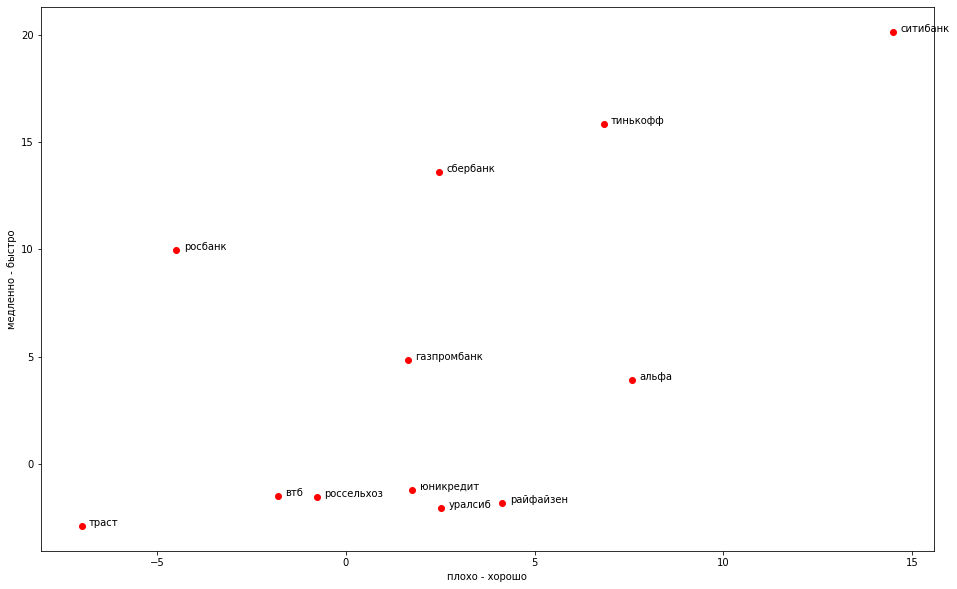

In [66]:
plt.figure(figsize=(16, 10))
plt.plot(vis_coord[0], vis_coord[1], 'ro')
plt.xlabel('плохо - хорошо')
plt.ylabel('медленно - быстро')
ax = plt.gca()
for i, annot in enumerate(banks):
    ax.annotate(annot, (vis_coord[0][i] + 0.2, vis_coord[1][i]))
    #ax.annotate(x['Точка'], (x['x'] + 0.2, x['y'])), axis=1)
plt.show()

Выводы: по результатам можно сделать сравнение банков между собою. например Тинькофф лучше чем Сбер как о быстроте, так и по качеству(хорошо\плохо)

## Задание 2. Распространение метки

Определим 6 позитивных слов: хороший, выгодный, надёжный, привлекательный, комфортный, клиентоориентировать

# Доработка

In [142]:
model_ru.wv.most_similar("хороший", topn=50)

[('плохой', 0.6579169034957886),
 ('неплохой', 0.6000245809555054),
 ('привлекательный', 0.5571333765983582),
 ('отличный', 0.5353251099586487),
 ('классный', 0.5321266055107117),
 ('выгодный', 0.5285319685935974),
 ('достойный', 0.522136390209198),
 ('приподнять', 0.5029800534248352),
 ('худой', 0.4973736107349396),
 ('вкусный', 0.4968172609806061),
 ('крутой', 0.49348247051239014),
 ('благоприятный', 0.4930840730667114),
 ('надёжный', 0.4881798326969147),
 ('радужный', 0.4859911799430847),
 ('испортиться', 0.4803064465522766),
 ('комфортный', 0.4778823256492615),
 ('улучшаться', 0.47004613280296326),
 ('клиенториентировать', 0.4696608781814575),
 ('конкурентоспособный', 0.4675328731536865),
 ('хорошеть', 0.4672792851924896),
 ('позитивный', 0.4657573103904724),
 ('прогрессивный', 0.46469828486442566),
 ('отсталый', 0.46168792247772217),
 ('панический', 0.46043795347213745),
 ('улучшать', 0.45773544907569885),
 ('технологичный', 0.45451533794403076),
 ('высокий', 0.4538331627845764),


In [150]:
positive =['привлекательный', 'комфортный', 'отличный', 'выгодный', 'надёжный', 'клиентоориентировать']
[model_ru.wv.key_to_index[word] for word in positive]

[2362, 3918, 1125, 991, 1904, 3020]

Определим 6 негативных слов: испортиться, негативный, слабый, медленный, посредственный, неклиентоориентированность

In [168]:
model_ru.wv.most_similar("плохой", topn=30)

[('хороший', 0.6579167246818542),
 ('ужасный', 0.6082869172096252),
 ('испортиться', 0.5933479070663452),
 ('отвратительный', 0.5452519655227661),
 ('негативный', 0.5334824323654175),
 ('скверный', 0.5227479338645935),
 ('слабый', 0.5095800757408142),
 ('лестный', 0.4891335070133209),
 ('идеальный', 0.4881150424480438),
 ('дурной', 0.4748367369174957),
 ('медленный', 0.47116824984550476),
 ('отвратный', 0.46873176097869873),
 ('панический', 0.4645009934902191),
 ('портиться', 0.46310141682624817),
 ('крутой', 0.46030527353286743),
 ('поганый', 0.45978569984436035),
 ('улучшаться', 0.45733770728111267),
 ('подпортить', 0.45724400877952576),
 ('отсталый', 0.45306333899497986),
 ('приподнять', 0.45150741934776306),
 ('подпортиться', 0.44951048493385315),
 ('отстойный', 0.44869524240493774),
 ('совковый', 0.44862818717956543),
 ('посредственный', 0.4473053812980652),
 ('запоминаться', 0.4464270770549774),
 ('ухудшиться', 0.44216248393058777),
 ('безобразный', 0.4405069351196289),
 ('мерзки

In [151]:
negative = ['совковый', 'отсталый','слабый', 'медленный', 'очередь', 'ужасный']
[model_ru.wv.key_to_index[word] for word in negative]

[4073, 10338, 3853, 3635, 119, 1366]

In [152]:
positive+negative

['привлекательный',
 'комфортный',
 'отличный',
 'выгодный',
 'надёжный',
 'клиентоориентировать',
 'совковый',
 'отсталый',
 'слабый',
 'медленный',
 'очередь',
 'ужасный']

In [23]:
#words = ['хороший', 'выгодный', 'надёжный', 'испортиться', 'негативный', 'слабый']
words = positive+negative
for i in range(len(g.vs)):
    g.vs[i]['key'] = words[i]
g.vs['color'] = ['blue','red', 'yellow','pink','green','brown','orange']
g.vs['label'] = ['хороший', 'выгодный', 'надёжный', 'испортиться', 'негативный', 'слабый']
g.add_edges([(0,1), (0,2), (0,3), (0,4), (0,5), (1,0), (1,2), (1,3), (1,4), (1,5), (2, 0), (2,1),(2,3), (2,4), (2,5), (3,0), (3,1), (3,2), (3,4), (3,5), (4,0), (4,1), (4,2), (4,3), (4,5)])

In [169]:
words = positive+negative
g = graf.Graph(directed = True)
g.add_vertices(len(words))
#g.vs['color'] = ['blue','red', 'yellow','pink','green','brown','orange']
g.vs['label'] = words

for i in range(len(g.vs)):
    for j in range(len(g.vs)):
        if i != j:
            g.add_edges([(i, j)])
            if dot(model_ru.wv.get_vector(g.vs[i]['label']), model_ru.wv.get_vector(g.vs[j]['label'])) >= 0:
                g.es[g.get_eid(i, j)]['weight'] = dot(model_ru.wv.get_vector(g.vs[i]['label']), model_ru.wv.get_vector(g.vs[j]['label']))
                g.es[g.get_eid(i, j)]['label'] = dot(model_ru.wv.get_vector(g.vs[i]['label']), model_ru.wv.get_vector(g.vs[j]['label']))
            else:
                g.es[g.get_eid(i, j)]['weight'] = 0
                g.es[g.get_eid(i, j)]['label'] = 0
               
            #g.es[g.get_eid(i, j)]['label'] = g.vs[i]['label'] + '-' + g.vs[j]['label']

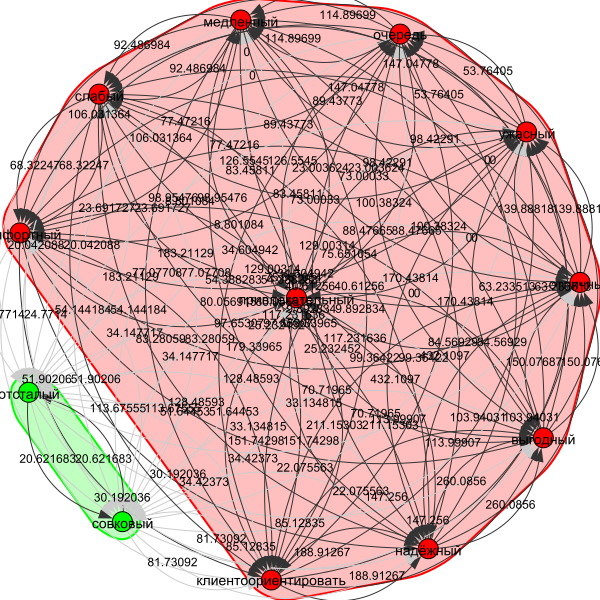

In [170]:
g.vs['initial'] = [1, 1, 1, 1, -1, -1, 0, 0, 0, 0, -1, -1]
g.vs['fixed'] = [True,  True, False, False, False, False,      True,  True, False, False, False, False]

labelProp = g.community_label_propagation(weights=g.es["weight"], initial = g.vs['initial'], fixed = g.vs['fixed'])
graf.plot(labelProp,mark_groups = True,**visual_style)

In [167]:
labelProp[0]

[0, 1, 2, 3, 4, 5, 8, 9, 10, 11]

к сущесвтуеющим 6 положительным и 6 отрицательным словам я добавляю еще 400 схожих слов (удаляю из них 12 первых если встречаются). далее добавляю их к спискам параметров-атрибутов графа из примера выше.

In [176]:
wordbank = [i[0] for i in model_ru.wv.most_similar("плохой", topn=400)]

In [178]:
for i in words:
    if i in wordbank:
        wordbank.remove(i)

In [180]:
words_wide = words + wordbank

g = graf.Graph(directed = True)
g.add_vertices(len(words_wide))
g.vs['label'] = words_wide

for i in range(len(g.vs)):
    for j in range(len(g.vs)):
        if i != j:
            g.add_edges([(i, j)])
            if dot(model_ru.wv.get_vector(g.vs[i]['label']), model_ru.wv.get_vector(g.vs[j]['label'])) >= 0:
                g.es[g.get_eid(i, j)]['weight'] = dot(model_ru.wv.get_vector(g.vs[i]['label']), model_ru.wv.get_vector(g.vs[j]['label']))
                g.es[g.get_eid(i, j)]['label'] = dot(model_ru.wv.get_vector(g.vs[i]['label']), model_ru.wv.get_vector(g.vs[j]['label']))
            else:
                g.es[g.get_eid(i, j)]['weight'] = 0
                g.es[g.get_eid(i, j)]['label'] = 0

In [185]:
# -1 помечаем unlabled слова, которые должны после применения label propagation добавиться в кластер
g.vs['initial'] = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0] + [-1 for _ in range(len(wordbank))]
g.vs['fixed'] = [True,  True, True, True, True, True,      True,  True, True, True, True, True]  + [False for _ in range(len(wordbank))]

labelProp = g.community_label_propagation(weights=g.es["weight"], initial = g.vs['initial'], fixed = g.vs['fixed'])
#graf.plot(labelProp,mark_groups = True,**visual_style)

Количество позитивных слов (помечены 1):

In [188]:
len(labelProp[0])

396

Количество негативных слов (помечены 0):

In [195]:
len(words_wide) - len(labelProp[0])

6

In [196]:
#номера слов-вершин, которые отсутствуют соответсвуют негативным словам
labelProp[0][:15]

[0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Вывод: Как видим label propogation пометил все неопределнные вершины как позитивные кроме тех, что мы явно указали как негативные. В качестве дополнитеьлных точек  брал именно similarity для негативных слов (содержат и позитивные). то есть по идее должен был пометить большую часть нулями.

## Правильное решение Label Popagation

In [288]:
%time model_ru3k = word2vec.Word2Vec(sentences, workers=4, vector_size=300, min_count=10, window=10, sample=1e-3, max_vocab_size = 5000) 

Wall time: 3min 28s


In [291]:
model_ru3k.wv.most_similar("хороший", topn=100)

[('плохой', 0.6452822685241699),
 ('неплохой', 0.6182431578636169),
 ('выгодный', 0.5550901889801025),
 ('отличный', 0.5308418869972229),
 ('надёжный', 0.5195242762565613),
 ('высокий', 0.49747663736343384),
 ('худой', 0.4852026402950287),
 ('низкий', 0.4750441908836365),
 ('удобный', 0.45745277404785156),
 ('идеальный', 0.45097941160202026),
 ('дорогой', 0.4477413594722748),
 ('приятный', 0.44714319705963135),
 ('лояльный', 0.443817675113678),
 ('ужасный', 0.43411460518836975),
 ('рынок', 0.41063040494918823),
 ('нравиться', 0.4007203280925751),
 ('довольный', 0.3961315155029297),
 ('многий', 0.3954959809780121),
 ('замечательный', 0.392386794090271),
 ('супер', 0.37882891297340393),
 ('негативный', 0.3694559335708618),
 ('красивый', 0.3622298240661621),
 ('понравиться', 0.36135369539260864),
 ('выгодно', 0.3608029782772064),
 ('радовать', 0.35803812742233276),
 ('печально', 0.3553372621536255),
 ('ниже', 0.3544730246067047),
 ('разочаровать', 0.353174090385437),
 ('отвратительный', 0

In [293]:
positive =['быстрый', 'лояльный', 'отличный', 'выгодный', 'надёжный', 'выгодно']

In [292]:
model_ru3k.wv.most_similar("плохой", topn=100)

[('хороший', 0.6452822089195251),
 ('ужасный', 0.6173161268234253),
 ('негативный', 0.5766584873199463),
 ('отвратительный', 0.5535291433334351),
 ('идеальный', 0.48840150237083435),
 ('разочаровать', 0.4419557452201843),
 ('отличный', 0.4015204906463623),
 ('обидный', 0.39913100004196167),
 ('неплохой', 0.39843279123306274),
 ('плохо', 0.3965288996696472),
 ('худой', 0.3914995491504669),
 ('низкий', 0.38868248462677),
 ('надёжный', 0.3874654769897461),
 ('портить', 0.3869548439979553),
 ('испортить', 0.3841519355773926),
 ('страшный', 0.3818973898887634),
 ('негатив', 0.3613095283508301),
 ('печально', 0.3598860204219818),
 ('тяжёлый', 0.3570123016834259),
 ('неприятный', 0.3505280017852783),
 ('многий', 0.3494504988193512),
 ('резко', 0.3487113416194916),
 ('сильно', 0.3479378819465637),
 ('любить', 0.3465855121612549),
 ('серьёзный', 0.34321045875549316),
 ('нравиться', 0.3427729308605194),
 ('отрицательный', 0.3389572501182556),
 ('рейтинг', 0.33639413118362427),
 ('лояльный', 0.33

In [294]:
negative = ['испортить', 'некомпетентный','далеко', 'обман', 'негативный', 'ужасный']

In [349]:
g = graf.Graph(directed = True)
keys = list(model_ru3k.wv.key_to_index)
#for word in keys:
#    g.add_vertex(word)

labels = []
fixes = []
weights = []

for word in keys:
    label = -1
    fix = False
    if word in positive:
        label = 1
        fix = True
    if word in negative:
        label = 0
        fix = True
    labels.append(label)
    fixes.append(fix)
    g.add_vertex(word)
i=0
for word in keys:
    if i% 100 == 0: 
        print('---', word, i)
    i += 1
    node = g.vs.select(name = word).indices[0]
    similarwords = model_ru3k.wv.most_similar(word, topn=10)
    for sim in similarwords:
        word1 = sim[0]
        val = sim[1]
        #print(word1)
        newnode = g.vs.select(name=word1).indices[0]
        #print('select ', word1)
        g.add_edge(node, newnode, weight = val)
        #print('add_edge ', word1)
        weights.append(val)

--- в 0
--- решить 100
--- оплата 200
--- операционист 300
--- россия 400
--- воспользоваться 500
--- заказать 600
--- тип 700
--- блокировка 800
--- коллега 900
--- страна 1000
--- вести 1100
--- з 1200
--- известно 1300
--- создать 1400
--- удивлённый 1500
--- доверие 1600
--- верно 1700
--- чип 1800
--- немедленно 1900
--- предпринять 2000
--- виктор 2100


In [ ]:
max_vocab_size

In [351]:
len(labels)

2190

In [371]:
w = list(g.es['weight'])

In [352]:
m = g.community_label_propagation(weights = weights, initial = labels, fixed = fixes)

In [370]:
print('количество помеченных как позитивные слова', len(m[1]))
print('количество помеченных как неготивные слова', len(m[0]))

количество помеченных как позитивные слова 1491
количество помеченных как неготивные слова 682


In [366]:
np.array(keys)[m[0]]

array(['в', 'я', 'и', 'не', 'на', 'что', 'с', 'по', 'весь', 'а', 'мой',
       'как', 'но', 'то', 'который', 'отделение', 'вы', 'они',
       'сотрудник', 'она', 'он', 'от', 'же', 'свой', 'сказать', 'из',
       'заявление', 'мы', 'только', 'какой', 'если', 'ответ', 'офис',
       'телефон', 'когда', 'ваш', 'номер', 'бы', 'банкомат', 'проблема',
       'или', 'чтобы', 'ни', 'без', 'ситуация', 'звонок', 'человек',
       'где', 'почему', 'вот', 'там', 'смс', 'услуга', 'заявка', 'просто',
       'очередь', 'ли', 'обратиться', 'даже', 'знать', 'девушка', 'ничто',
       'претензия', 'сам', 'говорить', 'никакой', 'оператор', 'сообщить',
       'ответить', 'да', 'ну', 'наш', 'кто', 'хотя', 'тут', 'центр',
       'имя', 'себя', 'теперь', 'вообще', 'также', 'потом', 'вс', 'дело',
       'никто', 'решение', 'служба', 'специалист', 'прийти', 'обращение',
       'отзыв', 'опять', 'москва', 'итог', 'тоже', 'узнать', 'сейчас',
       'менеджер', 'пока', 'касса', 'история', 'думать', 'слово',
     

In [368]:
list(np.array(keys)[m[1]])

['быть',
 'банка',
 'карта',
 'это',
 'банк',
 'о',
 'за',
 'к',
 'деньга',
 'день',
 'год',
 'кредит',
 'тот',
 'так',
 'клиент',
 'мочь',
 'счёт',
 'для',
 'один',
 'этот',
 'сумма',
 'уже',
 'такой',
 'через',
 'до',
 'рубль',
 'вопрос',
 'раз',
 'дать',
 'время',
 'при',
 'том',
 'нет',
 'ещё',
 'получить',
 'кредитный',
 'после',
 'вклад',
 'платёж',
 'другой',
 'договор',
 'звонить',
 'сбербанк',
 'очень',
 'позвонить',
 'месяц',
 'написать',
 'два',
 'работать',
 'средство',
 'работа',
 'документ',
 'есть',
 'решить',
 'хотеть',
 'операция',
 'информация',
 'должный',
 'большой',
 'сделать',
 'срок',
 'можно',
 'обслуживание',
 'минута',
 'сегодня',
 'ждать',
 'сайт',
 'просить',
 'интернет',
 'процент',
 'неделя',
 'самый',
 'являться',
 'данный',
 'более',
 'далее',
 'чем',
 'стать',
 'надо',
 'нужно',
 'несколько',
 'оформить',
 'перевод',
 'писать',
 'комиссия',
 'следующий',
 'е',
 'иметь',
 'пользоваться',
 'условие',
 'момент',
 'задолженность',
 'взять',
 'течение',
 'сл

Попробуем еще метод Walk_trap, но тут мы не подсказываем алгоритму классы. о сам выделяет нужное количество классов.  В качестве гипер-параметра используем step^

In [267]:
wtrapweights = g.community_walktrap(weights=g.es["weight"], steps = 2)
clustweights=wtrapweights.as_clustering()

In [268]:
#количество элементов первого 2го класса
len(clustweights[2])

200

In [269]:
#количество кластеров
len(clustweights)

3

In [270]:
i = 0
for cluster in clustweights:
    print('\nCluster ', i, ':')
    print([g.vs[word_id]['label'] for word_id in cluster])
    i +=1


Cluster  0 :
['привлекательный', 'комфортный', 'выгодный', 'надёжный', 'клиентоориентировать', 'отсталый', 'слабый', 'хороший', 'крутой', 'отстойный', 'клиенториентировать', 'низок', 'человечный', 'ненадёжный', 'средненький', 'жадный', 'неповоротливый', 'достойный', 'высокотехнологичный', 'убогий', 'популярный', 'низкий', 'неплохой', 'технологичный', 'классный', 'сладкое', 'клиентоориентированный', 'тормозной', 'забюрократизировать', 'надёжность', 'неэффективный', 'нравиться', 'продвинуть', 'клиентоориентированый', 'гуманный', 'низка', 'слабоватый', 'впечатляющий', 'прибыльный', 'богатый', 'развитый', 'передовой', 'многий', 'консервативный', 'прогрессивный', 'дружественный', 'распространить', 'раскрутить', 'удачный', 'параноидальный', 'топовый', 'серьёзный', 'устойчивый', 'высокий', 'престижный', 'пожалуй', 'стабильность', 'неудобный', 'опасный', 'подкупать', 'мощный', 'перспективный', 'дистанционность', 'качественный', 'соблазнительный', 'креативный', 'бардачный', 'кусаться', 'корявы

Похоже в певых двух кластера присутствую преимуществнно положительные слова, а в последнем - негативные. в общем так себе распредлеение.

In [ ]:
graf.plot(clustweights,mark_groups = True,**visual_style)

# Окончание исправления

In [71]:
from sklearn.semi_supervised import LabelPropagation

In [309]:
lpa = LabelPropagation()

In [440]:
negative_index = [model_ru.wv.key_to_index[word] for word in negative]
positive_index = [model_ru.wv.key_to_index[word] for word in positive]

In [331]:
sample_size_lp = len(model_ru.wv.vectors)
sample_lp = model_ru.wv.vectors[:sample_size_lp+1]

In [441]:
labels = np.full(sample_size_lp, -1)
labels[positive_index] = 1
labels[negative_index] = 0

In [449]:
print('количество 1: ', (labels==1).sum(), '; колиество 0: ', (labels==0).sum(), '; количество -1: ', (labels==-1).sum())

количество 1:  6 ; колиество 0:  6 ; количество -1:  24542


In [450]:
lp_model = lpa.fit(sample_lp, labels)

In [452]:
(lp_model.transduction_==1).sum()

6

Вывод: мы задавали 6 положительных 6 отрицательных слов. в итоге колчество положительных слов таким же и осталось, то есть алгоритм не unlabeled данные опметил нулями. я пробовал использовать ранзные методы rfc, knn с ращличными гиперпараметрами, но результат остался тем же.
Я предположил, что размер датасета большой, а количество рамеченных данных малое. ниже сделал искуственный датасет с резмером 178 слов и промаркировал единиц 10шт, нулей 8 шт. В итоге имеем тот же результат, что и выше: количество единиц тоже, что и раньше, а все остальное он пометил нулями. Ниже я пробовал и алгоритм LabelSpreading, результаты которого остались неименными

In [347]:
#плохой - 879
negative1 = [879]
for word in model_ru.wv.most_similar("плохой", topn=500):
    if model_ru.wv.key_to_index[word[0]] < 5000:
        negative1.append(model_ru.wv.key_to_index[word[0]])

In [351]:
#хороший - 203
positive1 = [203]
for word in model_ru.wv.most_similar("хороший", topn=500):
    if model_ru.wv.key_to_index[word[0]] < 5000:
        positive1.append(model_ru.wv.key_to_index[word[0]])

In [411]:
posineg = list(set(positive1 + negative1))

In [412]:
len(posineg)

182

In [413]:
labels1 = np.full(len(posineg),-1)
for i,word_ind in enumerate(posineg):
    if word_ind in positive1[:10]:
        labels1[i] = 1
    elif word_ind in negative1[:10]:
        labels1[i] = 0
    else: continue

In [432]:
print('количество 1: ', (labels1==1).sum(), 'колиество 0: ', (labels1==0).sum())

количество 1:  10 колиество 0:  8


In [418]:
sample_lp1 = model_ru.wv.vectors[posineg]

In [419]:
lpa1 = LabelPropagation()
lp_model1 = lpa1.fit(sample_lp1, labels1)

In [435]:
(lp_model1.transduction_==1).sum()

10

In [433]:
lp_model1.transduction_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

Попробуем алгоритм LabelSpreading

In [244]:
from sklearn.semi_supervised import LabelSpreading
ls = LabelSpreading()

In [245]:
ls_model = lpa.fit(sample_lp, labels)

In [247]:
(ls_model.transduction_== 0).sum()

4994

In [451]:
print('количество 1: ', (ls_model.transduction_==1).sum(), '; колиество 0: ', (ls_model.transduction_==0).sum(), '; количество -1: ', (ls_model.transduction_==-1).sum())

количество 1:  6 ; колиество 0:  4994 ; количество -1:  0


In [186]:
#попытался нарисовать графф. тоже неуспех 
import igraph as ig


g = ig.Graph(directed=True)
for word in model_ru.wv.index_to_key:
    g.add_vertex(word)

for word in model_ru.wv.index_to_key:
    node = g.vs.select(name = word).indices[0]
    #print('node =', g.vs.select(name = word).indices)
    similar_words = model_ru.wv.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        #print(word)
        #print(model_ru.wv.most_similar(word, topn=5))
        #print(sim)
        #print(g.vs.select(name = word1).indices)
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)

In [241]:
layout = g.layout()

AttributeError: module 'igraph.layout' has no attribute 'coords'

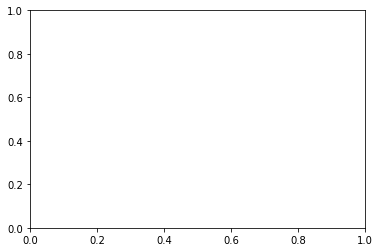

In [242]:
from igraph import *
fig, ax1 = plt.subplots()
#plot(g, layout=layout, target=ax)
plot(g, layout=layout, target=ax1)